In [1]:
import numpy as np
import os
from tensorflow import keras
# from keras.callbacks import EarlyStopping
from sklearn.preprocessing import minmax_scale
import matplotlib.pyplot as plt

In [2]:
%cd /Users/Kunal/Projects/TCH_CardiacSignals_F20/

/Users/kunal/Projects/TCH_CardiacSignals_F20


In [3]:
file_index = "1"
data = np.load(os.path.join("Working_Data", "Normalized_Fixed_Dim_HBs_Idx" + file_index + ".npy"))

In [15]:
reduced_dim = 1
all_leads_reconstructed = np.empty([len(data),100,4])
all_leads_encoded = np.empty([len(data), reduced_dim, 4])

input_hb = keras.Input(shape = (100,4))
# es = keras.callbacks.EarlyStopping(monitor='loss', mode='min', verbose=1, patience=10)
encoded = keras.layers.Dense(reduced_dim, activation = 'tanh')(input_hb)
decoded = keras.layers.Dense(400, activation = "tanh")(encoded)

# maps input to reconstruction
autoencoder = keras.Model(input_hb, decoded)

encoder = keras.Model(input_hb, encoded)

autoencoder.compile(optimizer='adam', loss = 'mse')

# callbacks=[es]
autoencoder.fit(data, data, epochs = 70, shuffle=False)

reconstruction = autoencoder.predict(data)
encode = encoder.predict(data)

all_leads_reconstructed[:,:,:] = reconstruction
all_leads_encoded[:,:,:] = encode
keras.backend.clear_session()

    # reconstruction_save = os.path.join("Working_Data", "reconstructed_ae_" + str(encoding_dim) + "d_Idx" + str(file_index) + ".npy")
    # encoded_save = os.path.join("Working_Data", "reduced_vae_" + str(encoding_dim) + "d_Idx" + str(file_index) + ".npy")
    # np.save(reconstruction_save, all_leads_reconstructed)
    # np.save(encoded_save,all_leads_encoded)

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: flatten_3/Reshape:0


ValueError: Graph disconnected: cannot obtain value for tensor Tensor("input_12:0", shape=(None, 100, 4), dtype=float32) at layer "flatten_3". The following previous layers were accessed without issue: []

In [17]:
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, InputLayer
from tensorflow.keras.models import Sequential, Model

def build_autoencoder(img_shape, code_size):
    # The encoder
    encoder = Sequential()
    encoder.add(InputLayer(img_shape))
    encoder.add(Flatten())
    encoder.add(Dense(code_size))

    # The decoder
    decoder = Sequential()
    decoder.add(InputLayer((code_size,)))
    decoder.add(Dense(np.prod(img_shape))) # np.prod(img_shape) is the same as 32*32*3, it's more generic than saying 3072
    decoder.add(Reshape(img_shape))

    return encoder, decoder

In [20]:
# Same as (32,32,3), we neglect the number of instances from shape
SIG_SHAPE = data.shape[1:]
encoder, decoder = build_autoencoder(SIG_SHAPE, 1)

inp = Input(SIG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = Model(inp,reconstruction)
autoencoder.compile(optimizer='adam', loss='mse')

print(autoencoder.summary())

Model: "functional_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 100, 4)]          0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 401       
_________________________________________________________________
sequential_3 (Sequential)    (None, 100, 4)            800       
Total params: 1,201
Trainable params: 1,201
Non-trainable params: 0
_________________________________________________________________
None


In [29]:
mod = autoencoder.fit(x=data, y=data, epochs=20)

Epoch 1/20
1449/1449 [==============================] - 2s 1ms/step - loss: 0.1073

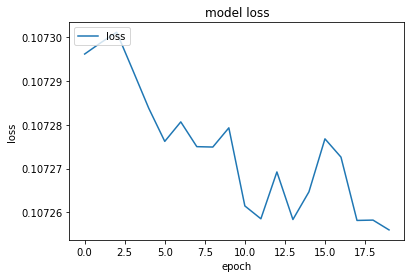

In [31]:
plt.plot(mod.history['loss'])
# plt.plot(mod.history['reconstruction_loss'])
# plt.plot(history.history['kl_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss'], loc='upper left')
plt.show()

In [32]:
mod.history.keys()

dict_keys(['loss'])